In [ ]:
# This code is part of qhack2022-hackeinberg-project.
#
# (C) Copyright NTNU QuCAI-Lab, 2022.
#
# This code is licensed under the Creative Commons Zero v1.0 Universal License. 
# You may obtain a copy of the License at https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project/blob/dev/LICENSE.md.

[![Maintenance](https://img.shields.io/badge/Maintained%3F-yes-green.svg)](https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project/graphs/commit-activity)
[![Build Status](https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project/actions/workflows/tests.yml/badge.svg?branch=dev)](https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project/actions/workflows/tests.yml)
[![Release](https://img.shields.io/github/release/QuCAI-Lab/qhack2022-hackeinberg-project.svg)](https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project/releases)
[![commit](https://img.shields.io/github/last-commit/QuCAI-Lab/qhack2022-hackeinberg-project)](https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project/commits)
[![Forks](https://img.shields.io/github/forks/QuCAI-Lab/qhack2022-hackeinberg-project)](https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project/fork)

<div align="center">
  <h1> <a href="https://qhack.ai/events#hackathon-challenges"> QHack2022 Open Hackaton </a> - Hackeinberg Team Project </h1>
  <h2> Extending Adaptive Methods for Finding an Optimal Circuit Ansatze in VQE Optimization</h2>
</div>
<br>

<center> <b>Authors: ¹Lucas Camponogara Viera, ²José Paulo Marchezi</b></center>
<center>
<b><a target="_blank" href="https://en.ntnu.edu.tw/">¹National Taiwan Normal University - NTNU, Taipei, Taiwan</a></b>.
<br>
<b><a target="_blank" href="https://www.gov.br/inpe/pt-br">²National Institute for Space Research - INPE, São José dos Campos, SP, Brazil.</a></b>.
<br>
<b><a target="_blank" href="http://english.nssc.cas.cn/">²State  Key  Laboratory  of  Space  Weather,  National  Space  Science  Center, Chinese  Academy  of  Sciences, China</a></b>.
</center>

<!--  -->

<br>

[comment]: <> ()
<table class="tfo-notebook-buttons" align="head">
  <td>
    <a target="_blank" href="https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /></a>
  </td>
</table>

<center><a href="https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project"><b>View source on GitHub.</b></a></center>

    


In [74]:
%autosave 30

Autosaving every 30 seconds


---

In this jupyter notebook, the authors describe a step-by-step implementation of a hybrid quantum-classical optimization approach to find the optimal gate arrangement of a problem-specific ansatze (circuit Ansatz). We demonstrate said approach to find the ground state of the LiH molecule.

---

# **Project Description**


## Background and Motivation


Most widely considered hardware-efficient and Chemistry-inspired ansatze, although generic, suffer from either barren plateaus [[1](https://www.nature.com/articles/s41467-018-07090-4)] or inconsistency under low-order trotterization steps [[2](https://pubs.acs.org/doi/abs/10.1021/acs.jctc.9b01083)], respectively. To circumvent this drawback, different algorithms for optimization of variational quantum circuits (VQA), the so-called adaptive circuits, have already been proposed in the literature [[4](https://pennylane.ai/qml/demos/tutorial_adaptive_circuits.html)]. One example is the Adaptive Derivative-Assembled Pseudo-Trotter ansatz Variational Quantum Eigensolver (ADAPT-VQE) [[3](https://www.nature.com/articles/s41467-019-10988-2)]. In a nutshell, the ADAPT-VQE approach is to grow the ansatz by adding fermionic operators one-at-a-time so to preserve the amount of correlation energy. This approach can also be regarded as a particular optimization procedure for Full Configuration Interaction (FCI) VQE.

In this work, we extended some of the existing methods applied to the hybrid quantum-classical VQE [[5](https://doi.org/10.1038/ncomms5213)] algorithm for the particular case of the ground state of the LiH molecule. We prioritized the minimization of the circuit depth (the longest sequence of gates acting on a qubit register) at the cost of increasing parameter count (the number of parameters to be optimized) given their tradeoff between difficulty in implementation on NISQ devices vs difficulty in optimization on classical computers, respectively. The baseline approach took into consideration the following features for a good ansatz:

1. Coherence friendly: the circuit must be shallow, i.e, have a small number of layers in order to be computed during a time window smaller than the decoherence time.
2. Hardware friendly (qubit routing): gate coupling allowed only between nearest-neighbor qubits to avoid SWAP gates during qubit routing (mapping from the circuit diagram to a hardware topology).
3. Small number of hyperparameters: we seek the minimum amount of angles to be optimized in order to avoid classical optimization overhead (when classical computation becomes too expensive).

In this first stage of the work, our goal was to find a quasi-optimal ansatz by restricting the VQE simulation to single and double order excitations only. For the future, we plan to use a deep reinforcement learning approach to learn an exact circuit ansatz considering higher excitation orders and the [Qamuy SDK](https://qamuy.qunasys.com/docs/en/) that was not possible given the short time window.




## Algorithm outline

1. With the spin orbitals of the molecule of interest, compute its second-quantized electronic Hamiltonian in the STO-3G basis.

2. Map the fermionic Hamiltonian given in terms of its fermionic operators into a spin qubit-equivalent Hamiltonian using either Bravyi-Kitaev or the inverted Jordan–Wigner transformation. This is required to perform gate-based quantum computation. The Hamiltonian will be used to compute the cost function that evaluate the expectation value of the Hamiltonian, while the number of qubits is required to obtain the electronic excitations and to set up the quantum circuit.

3. Obtain the single and double electronic excitations by acting with the electron annihilation and creation operators on the Hartree-Fock reference state.

4. Define a set with all unique single and double excitations to create the correspondent SO(2) unitary qubit gates (the particular Givens rotations) to each electronic excitation operator in order to build a quantum circuit ansatz of particle-conserving unitary qubit gates.

5. Initialize the qubit state to a reference Hartree-Fock state.

6. Initialize the parameter values of each gate in the ansatz to zero, i.e, initialize the ansatz to the identity matrix in order to compute the gradients with respect to the Hartree-Fock state.

7. Define the cost function as the expectation value of the qubit Hamiltonian. Define an optimizer (e.g. SGD).

8. Prepare the trial estate with the current ansatz.

9. Use the parameter shift rule to compute the gradient of the cost function with respect to its tunable parameters.

10. Identify the operators (gates) with the largest and smallest gradient. Replace the latter with the former. Remove gates whose gradient are smaller than a pre-defined threshold.

11.  Use the optimizer to update the circuit parameters according to a VQE experiment.

12. Define the convergence as the difference between the previous and the next expected value for the current optimization step. If the convergence tolerance is less than or equal to a pre-defined threshold $\epsilon$, exit the optimization loop and evaluate the cost metric of the final optimized circuit by measuring its circuit depth.

13. Repeat step 9.

## Outlook

For the future, we plan to use a deep reinforcement learning approach to learn an exact circuit ansatz considering higher excitation orders.

# &nbsp; <a href="https://creativecommons.org/licenses/by/4.0/"><img valign="middle" src="https://img.icons8.com/copyright" width="50"></a> License

In [ ]:
#@title Copyright 2022.
# This code is part of qhack2022-hackeinberg-project.
#
# (C) Copyright NTNU QuCAI-Lab, 2022.
#
# This code is licensed under the Creative Commons Zero v1.0 Universal License. 
# You may obtain a copy of the License at https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project/blob/dev/LICENSE.md.

# &nbsp; <a href="#"><img valign="middle" height="45px" src="https://img.icons8.com/python" width="45" hspace="0px" vspace="0px"></a> Dependencies

One may find the `requirements.txt` file at the official [GitHub repo](https://github.com/QuCAI-Lab/qhack2022-hackeinberg-project/blob/dev/requirements.txt).


## pip install

**Installing `Qamuy`, `PennyLane`, `pennylane-qchem`, `pyscf`, `openfermionpyscf`, `pylatexenc`, and `Watermak`.**



In [1]:
!pip --version

pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)


In [2]:
'''
# Installing a non-default library

!python3 -m pip install <library_name>

# Alternative 

!apt-get -qq install -y <library_name> && pip install -U <library_name> 

# Upgrading an installed library

!pip install <library_name> --upgrade
'''

'\n# Installing a non-default library\n\n!python3 -m pip install <library_name>\n\n# Alternative \n\n!apt-get -qq install -y <library_name> && pip install -U <library_name> \n\n# Upgrading an installed library\n\n!pip install <library_name> --upgrade\n'

**Qamuy:**

In [37]:
!python3 -m pip install qamuy-client --extra-index-url https://download.qamuy.qunasys.com/simple/

Looking in indexes: https://pypi.org/simple, https://download.qamuy.qunasys.com/simple/
User for download.qamuy.qunasys.com: qamuy
Password: 
     |████████████████████████████████| 77 kB 1.6 MB/s 
     |████████████████████████████████| 46 kB 2.1 MB/s 
     |████████████████████████████████| 3.6 MB 10.2 MB/s 
     |████████████████████████████████| 1.1 MB 41.1 MB/s 
     |████████████████████████████████| 454 kB 24.8 MB/s 
     |████████████████████████████████| 2.0 MB 47.2 MB/s 
     |████████████████████████████████| 54 kB 2.5 MB/s 
     |████████████████████████████████| 82 kB 1.0 MB/s 
  Created wheel for gcloud: filename=gcloud-0.18.3-py3-none-any.whl size=602937 sha256=fabbb2b30917d1f266c7bc1d584f3d416e24c8107826ee7103e36869946b08bd
  Stored in directory: /root/.cache/pip/wheels/50/9d/19/dc1a639905431252dbf8a61388a83459c5cfef7add445bebe4
Successfully built gcloud
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
 

**PennyLane:**

In [4]:
!python3 -m pip install PennyLane==0.21.0

In [5]:
!python3 -m pip install pennylane-qchem

**pyscf**:

In [6]:
!python3 -m pip install pyscf --user

**Open Fermion**:

In [7]:
!python3 -m pip install openfermionpyscf==0.5

**Native numpy:**

In [8]:
#!python -m pip install numpy==1.20.3

**pylatexenc**:

In [9]:
!python -m pip install pylatexenc

     |████████████████████████████████| 162 kB 5.2 MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136835 sha256=a6dd72a946c43c658ffa23833d0b346dc296e4aca3ea5cbc2934b200e951221d
  Stored in directory: /root/.cache/pip/wheels/f1/8a/f5/33ee79d4473eb201b519fa40f989b842e373237395a3421f52
Successfully built pylatexenc


**Watermark:**

In [35]:
!python -m pip install watermark

## Importing libraries


In [11]:
#import qamuy.chemistry as qy
#from qamuy.client import Client
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
import IPython
import sys
import time

In [12]:
%load_ext watermark
%watermark -a 'Lucas Camponogara Viera' -gu 'camponogaraviera' -ws 'https://qucai-lab.github.io/' -w -u -d -v -m -iv -r -b

Author: Lucas Camponogara Viera

Github username: camponogaraviera

Website: https://qucai-lab.github.io/

Last updated: 2022-02-25

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.144+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

Git repo: 

Git branch: 

sys            : 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
pennylane      : 0.21.0
pennylane_qchem: 0.21.0
IPython        : 5.5.0

Watermark: 2.3.0



In [13]:
qml.about()

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Name: PennyLane
Version: 0.21.0
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/XanaduAI/pennylane
Author: None
Author-email: None
License: Apache License 2.0
Location: /usr/local/lib/python3.7/dist-packages
Requires: appdirs, retworkx, semantic-version, pennylane-lightning, autoray, scipy, toml, numpy, autograd, networkx, cachetools
Required-by: PennyLane-Qchem, PennyLane-Lightning
Platform info:           Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic
Python version:          3.7.12
Numpy version:           1.21.5
Scipy version:           1.4.1
Installed devices:
- default.gaussian (PennyLane-0.21.0)
- default.mixed (PennyLane-0.21.0)
- default.qubit (PennyLane-0.21.0)
- default.qubit.autograd (PennyLane-0.21.0)
- default.qubit.jax (PennyLane-0.21.0)
- default.qubit.tf (PennyLane-0.21.0)
- default.qubit.torch (PennyLane-0.21.0)
- lightning.qubit (PennyLane-Lightning-0.21.0)


In [14]:
print(IPython.sys_info())

{'commit_hash': 'b467d487e',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/usr/local/lib/python3.7/dist-packages/IPython',
 'ipython_version': '5.5.0',
 'os_name': 'posix',
 'platform': 'Linux-5.4.144+-x86_64-with-Ubuntu-18.04-bionic',
 'sys_executable': '/usr/bin/python3',
 'sys_platform': 'linux',
 'sys_version': '3.7.12 (default, Jan 15 2022, 18:48:18) \n[GCC 7.5.0]'}


# &nbsp; <a href="#"><img valign="middle" height="45px" src="https://img.icons8.com/physics" width="45" hspace="0px" vspace="0px"></a> Implementation

**Algorithm**

- Steps 1 and 2 are implemented with the qchem.molecular_hamiltonian() function that returns both the fermionic-to-qubit transformed Hamiltonian and the number of qubits.

- Step 3 is implemented using the qchem.excitations() function.

- Step 4 are implemented with the SingleExcitation() and DoubleExcitation() classes, respectively, by passing the return of the qchem.excitations() function, i.e, the lists with the indices of the spin orbitals.

- Step 5 is implemented with the qml.BasisState class provided the HF state is obtained with the function qchem.hf_state function.

- Step 6 is a simple numpy tensor.

- At step 7, the cost function can be implemented either with the built-in ExpvalCost() class or as a custom function returning the expectation value of the circuit with the expval() class. The primary optimizer of choice is SGD defined by the GradientDescentOptimizer(stepsize=float) class.

- Step 9 is implemented with the grad() class. 

- Step 11 is computed using the GradientDescentOptimizer.step().




**Definitions**

- H: the molecular Hamiltonian of the system in the qubit representation.
- qubits: the number of qubits (int).
- singles: a list of 8 elements where each element is another list with 2 indices of the spin orbitals.
- doubles: a list of 16 elements where each element is another list with 4 indices of the spin orbitals.
- HF: a numpy.ndarray of shape ((10,) representing the Hartree-Fock state vector.
- cost(): a function that returns the expectation value of the Hamiltonian according to $\langle \psi_{HF}|U^{\dagger}HU|\psi_{HF}\rangle$.
- gates: a list containing the Givens rotations a.k.a particle-preserving operators.
- init_params: a list containing the zero angles of the initial ansatz.
- params: a numpy tensor containing all tunable angles.
- ansatz(): a function defining the quantum circuit and parametrized gates to be optimized.
- energy: a list containing the optimized expected values of the Hamiltonian.
- angles: a list containing the optimized angles for each gate in the ansatz.

## Pennylane

In [28]:
grads = np.array([2,4,5, 10])
sets=np.array([2,4,6,7])
maxpos = np.argmax(grads)
minpos = np.argmin(grads)
maxpos, minpos
sets[minpos] = sets[maxpos]
print(sets)
sets = [sets[i] for i in range(len(sets)) if abs(grads[i]) > 1.0e-6] # Step 10.
print(sets)

[7 4 6 7]
[tensor(7, requires_grad=True), tensor(4, requires_grad=True), tensor(6, requires_grad=True), tensor(7, requires_grad=True)]


In [31]:
#! /usr/bin/python3

import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt

def vanilla(params, H, HF, sets):
  """Main function to run the optimization loop.

  Args:
      - params (np.ndarray): the parameters to be optimized in the ansatz.

  Returns:
      - energy (np.ndarray): the expected value of the final (optmized) ansatz.
  """

  # Step 7.
  opt = qml.GradientDescentOptimizer(stepsize=0.4)  
  dev = qml.device("default.qubit", wires=qubits)
  
  # Step 8. 
  def ansatz(params, wires, to_gates):
    """Function that defines the circuit to be optimized."""
    qml.BasisState(HF, wires=wires) # Reference Hartree-Fock state.
    for i, elem in enumerate(to_gates):
      if len(elem) == 4:
        qml.DoubleExcitation(params[i], wires=elem)
      else:
        qml.SingleExcitation(params[i], wires=elem)

  cost = qml.ExpvalCost(ansatz, H, dev, optimize=True)
  energy = [cost(params, to_gates=sets)]
  epochs = 20
  conv_tol = 1e-07

  for n in range(epochs):
    circuit_gradient = qml.grad(cost, argnum=0)
    grads = circuit_gradient(params, to_gates=sets) # Step 9.
    if len(grads) == len(sets):
      maxpos = np.argmax(grads)
      minpos = np.argmin(grads)
      sets[minpos] = sets[maxpos]
    sets = [sets[i] for i in range(len(sets)) if abs(grads[i]) > 1.0e-5] # Step 10.
    np.append(sets, sets[maxpos])
    params, prev_energy = opt.step_and_cost(cost, params, to_gates=sets) # Step 11.
    energy.append(cost(params, to_gates=sets))
    conv = np.abs(energy[-1] - prev_energy) # Step 12.
    print(f"Epoch = {n},  Energy = {energy[-1]:.8f} Ha")
    if conv <= conv_tol:
      break

  print("\n" f"Optimized ground-state energy = {energy[-1]:.8f} Ha")

if __name__ == "__main__":
  #global qubits
  symbols = ["Li", "H"] # Begin of step 1.
  geometry = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 2.969280527], dtype=float)
  H, qubits = qml.qchem.molecular_hamiltonian(symbols, geometry, active_electrons=2, active_orbitals=5) # End of step 2.
  electrons = 2
  singles, doubles = qchem.excitations(electrons, qubits) # Step 3.
  sets = singles+doubles # Step 4.
  HF = qml.qchem.hf_state(electrons, qubits) # Step 5.
  params = np.zeros(len(sets), requires_grad=True) # Step 6.
  vanilla(params, H, HF, sets) # Begin the optimization loop.

Epoch = 0,  Energy = -7.86437978 Ha
Epoch = 1,  Energy = -7.86545790 Ha
Epoch = 2,  Energy = -7.86616076 Ha
Epoch = 3,  Energy = -7.86663388 Ha
Epoch = 4,  Energy = -7.86696096 Ha
Epoch = 5,  Energy = -7.86719187 Ha
Epoch = 6,  Energy = -7.86735749 Ha
Epoch = 7,  Energy = -7.86747769 Ha
Epoch = 8,  Energy = -7.86756565 Ha
Epoch = 9,  Energy = -7.86763043 Ha
Epoch = 10,  Energy = -7.86767834 Ha
Epoch = 11,  Energy = -7.86771389 Ha
Epoch = 12,  Energy = -7.86774034 Ha
Epoch = 13,  Energy = -7.86776006 Ha
Epoch = 14,  Energy = -7.86777478 Ha
Epoch = 15,  Energy = -7.86778579 Ha
Epoch = 16,  Energy = -7.86779403 Ha
Epoch = 17,  Energy = -7.86780021 Ha
Epoch = 18,  Energy = -7.86780485 Ha
Epoch = 19,  Energy = -7.86780834 Ha

Optimized ground-state energy = -7.86780834 Ha


## Initial Ansatz Visualization

In [33]:
dev = qml.device("default.qubit", wires=qubits)
@qml.qnode(dev)
def ansatz(params, wires):
  """Function that defines the circuit to be optimized."""
  qml.BasisState(HF, wires=wires) # Reference Hartree-Fock state.
  for pos, elem in enumerate(doubles):
    qml.DoubleExcitation(params[pos], wires=elem)
  for pos, elem in enumerate(singles):
    qml.SingleExcitation(params[pos], wires=elem)
  return qml.expval(H)

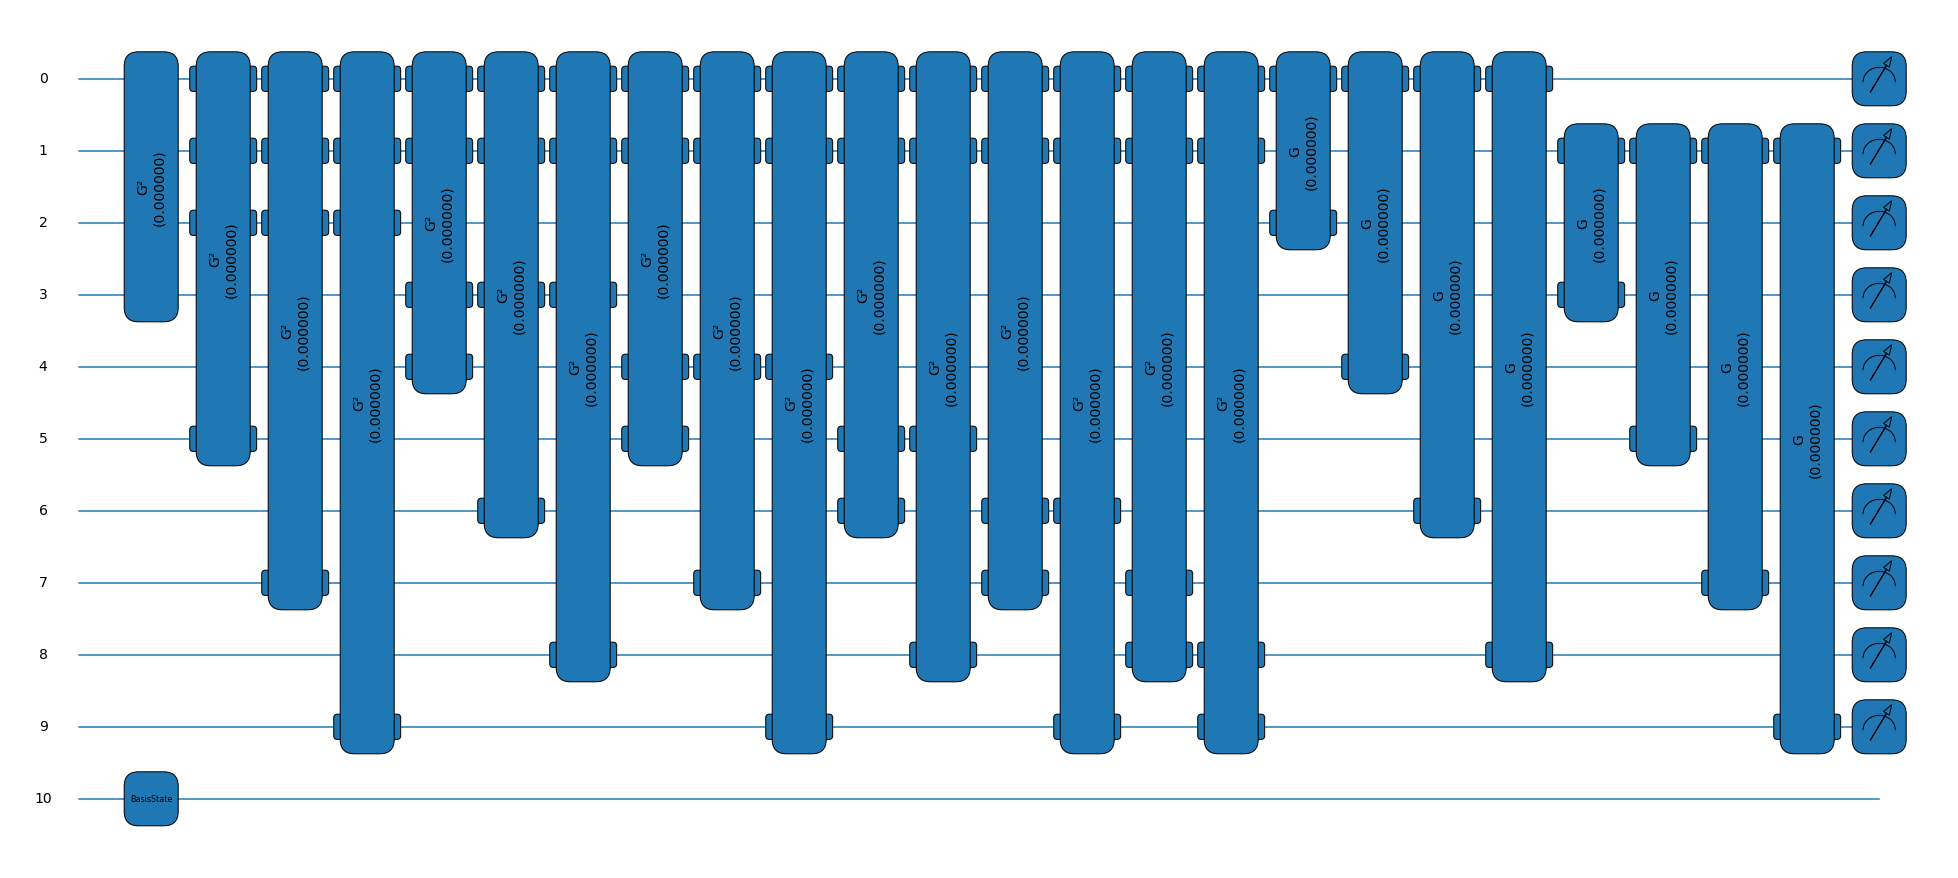

In [34]:
fig, ax = qml.draw_mpl(ansatz, decimals=6)(params, wires=qubits)

## Qamuy

In [36]:
MoleculeName = "name" #@param

In [ ]:
! qamuy reset-password

In [ ]:
!qamuy login

In [ ]:
qclient = Client(email_address="", password="")

In [ ]:
setting = qy.QamuyChemistryInput()